<a href="https://colab.research.google.com/github/KasperczakMikolaj/UM-w-finansach/blob/main/Case_3_Miko%C5%82aj_Kasperczak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12



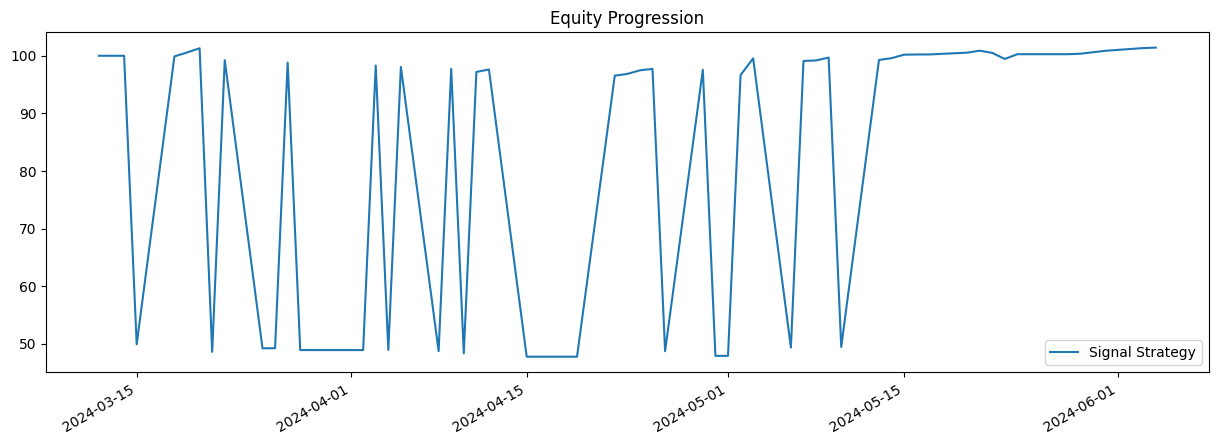

                           Signal Strategy
start                  2024-03-12 00:00:00
end                    2024-06-04 00:00:00
rf                                     0.0
total_return                      0.014175
cagr                              0.063115
max_drawdown                     -0.528769
calmar                            0.119363
mtd                               0.005457
three_month                            NaN
six_month                              NaN
ytd                               0.014175
one_year                               NaN
three_year                             NaN
five_year                              NaN
ten_year                               NaN
incep                             0.063115
daily_sharpe                      3.319694
daily_sortino                     8.162521
daily_mean                       26.780577
daily_vol                         8.067183
daily_skew                        0.849714
daily_kurt                       -0.303987
best_day   

In [6]:
!pip install ta bt yfinance matplotlib scikit-learn

import yfinance as yf
import pandas as pd
import ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import bt
import matplotlib.pyplot as plt

# Pobranie danych
start_date = "2024-01-01"
end_date = "2024-06-05"
data = yf.download("AAPL", start=start_date, end=end_date)

# Obliczanie wskaźników technicznych
data['SMA20'] = ta.trend.sma_indicator(data['Close'], window=20)
data['SMA50'] = ta.trend.sma_indicator(data['Close'], window=50)
data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
data['MACD'] = ta.trend.macd(data['Close'])
data = data.dropna()

# Przygotowanie danych do modelu
X = data[['SMA20', 'SMA50', 'RSI', 'MACD']]
y = (data['Close'].shift(-1) > data['Close']).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Trenowanie modelu
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Generowanie sygnałów
data['Signal'] = model.predict(X)
data['Signal'] = data['Signal'].shift(1).fillna(0)

# Przygotowanie danych do backtestu
data_bt = data[['Close', 'Signal']].copy()

class SelectWhere(bt.Algo):
    def __init__(self, signals):
        self.signals = signals

    def __call__(self, target):
        if target.now in self.signals.index:
            selected = self.signals.loc[target.now]
            if selected == 1:
                target.temp['selected'] = target.universe.columns
            else:
                target.temp['selected'] = []
        else:
            target.temp['selected'] = []
        return True

strategy = bt.Strategy('Signal Strategy', [SelectWhere(data_bt['Signal']),
                                           bt.algos.WeighEqually(),
                                           bt.algos.Rebalance()])
test = bt.Backtest(strategy, data_bt)
result = bt.run(test)

result.plot()
plt.show()
print(result.stats)

# Wyświetlanie wyników w formie tabelarycznej
results_df = pd.DataFrame(result.stats)
print(results_df)

